In [1]:
from scipy import sparse
import numpy as np

In [2]:

## Variable that CAN be changed
treatment_duration = 60*60  # [s] Vibrotactile stimulation duration
n_on_period = 3  # Number of on CR periods
n_off_period = 2  # Number of CR periods after on periods
dt = 1  # [ms] Time step size
n_regions = 5
f_burst = 100  # Hz
f_cr = 1  # [Hz] Coordinated Reset Frequency

## Calculated variables
isi =  int(f_burst**(-1) * 1e3)  # [ms] Inter-spike interval - Floor rounding
spikes_per_burst = int((f_cr**(-1)*1e3 / 5) / isi)  # Floor rounding
n_periods_per_set = n_on_period + n_off_period
period_length = f_cr ** (-1)  # [s] Time length per CR duration
n_set_in_treatment = int(treatment_duration / (n_periods_per_set * period_length))  # Floor rounding

## Catching the vibration motor limitations
## - The motors can vibrate at 200 rotations-per-sec, thus we need to make sure
##   that the f_burst freq is less than 200.

assert f_burst <=200, "Freq is too high, vibration motor requires freq to be under 200hz."

In [3]:
# Allocate the memory
non_zero_row_count = n_set_in_treatment * n_on_period * n_regions * spikes_per_burst
column_idx = np.zeros(shape=non_zero_row_count, dtype=int)
row_idx = np.zeros(shape=non_zero_row_count, dtype=int)
data_array = np.zeros(shape=non_zero_row_count, dtype=int)

# Tracking variable
global_clock = 0
global_idx = 0

# Fill the allocated arrays
for _ in range(n_set_in_treatment):
    for _ in range(n_on_period):
        order_of_regions = np.random.choice(n_regions, size=n_regions, replace=False)
        # print(order_of_regions)
        for region in order_of_regions:
            for _ in range(spikes_per_burst):
                column_idx[global_idx] = region
                row_idx[global_idx] = global_clock
                data_array[global_idx] = 1

                # print(f"  {global_idx} ({global_clock}, {region}) = {data_array[global_idx]}")
                global_idx += 1  # Increment for data creation
                global_clock += isi

    for _ in range(n_off_period):
        global_clock += isi * spikes_per_burst * n_regions

# Build 2D array
treatment_schedule = sparse.csr_array((data_array, (row_idx, column_idx)), dtype=int)
temp_mat = np.zeros(shape=(treatment_schedule.shape), dtype=int)
treatment_schedule.toarray(out=temp_mat)

# Save to CSV
np.savetxt("treatment_schedule.txt", X=treatment_schedule.toarray(), 
           delimiter=',', 
           fmt="%d")

In [5]:
# Sanity Check
# print(treatment_schedule.shape)
# # print(data_array)
# print("  row", row_idx[:20])
# print("  col", column_idx[:20])
# print("  data", data_array[:20])

# print(row_idx.shape, column_idx.shape, data_array.shape)

# print(treatment_schedule[0, 0])
# print(treatment_schedule.nnz)

# print(treatment_schedule.toarray()[0:20, :])

[[      0       0       0 ...       0       0       0]
 [      0       0       0 ... 3597985 3597990 3597995]
 [      0       0       0 ...       0       0       0]
 [      0       5      10 ...       0       0       0]
 [      0       0       0 ...       0       0       0]]
5


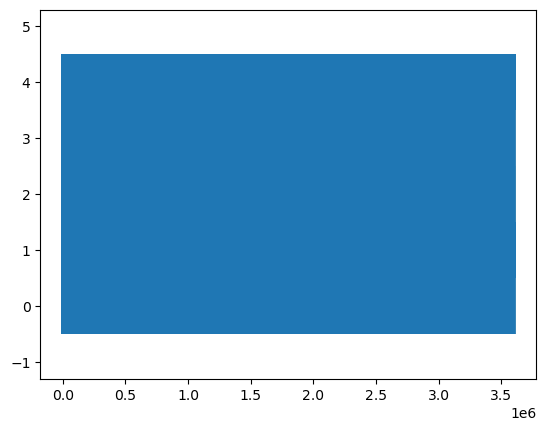

In [6]:
# Plot
import pandas as pd
import matplotlib.pyplot as plt

window = (0, 2000)  # zoom in window in milliseonds

temp = pd.DataFrame({"time_ms": row_idx, "region": column_idx}, dtype=int)
temp = temp.pivot(index="time_ms", columns="region", values="time_ms").fillna(0).astype(int).to_numpy().T
print(temp)


holding_list = []
for i, row in enumerate(temp):
    holding_list.append(row[row!=0])

print(len(holding_list))

fig, ax = plt.subplots()
plt.eventplot(holding_list)